In [58]:
import numpy as np
import pandas as pd
#import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


In [59]:
data = pd.read_excel("DAB12.xlsx", sheet_name="exo")
dataset = data.drop(['Name','Class',\
                     'Dist_DAB',\
                     'E1_elec', 'E1_polar', 'E1_ct', 'E1_solv',\
                     'E2_elec', 'E2_Pauli', 'E2_polar', 'E2_ct', 'E2_solv',\
                     'E3_elec', 'E3_disp', 'E3_polar', 'E3_ct', 'E3_solv'], axis = 1)

name = dataset.drop('deltaG', axis = 1)


In [60]:
####################
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h, h


In [61]:
####################
def calc_feature_importances(data, model, data_iterations, cv_iterations):
    # Track overall average feature importances
    overall_average_importances = []
    for i in range(0, len(data.columns)-1):
        overall_average_importances.append([])

    X = data.drop('deltaG', axis = 1)
    y = data['deltaG']
    # Iterate through data selection iterations
    importances_all = []
    for i in range(0, data_iterations):

        # Track importances at each iteration
        cv_importances = []
        for i in range(0, len(X.columns)):
            cv_importances.append([])

        # Do N fold training on selected subset, record feature importances
        for i in range(0, cv_iterations):
            model.fit(X, y)
            importances = list(model.feature_importances_)
            importances_all.append(model.feature_importances_)
            for j in range(0, len(importances)):
                cv_importances[j].append(importances[j])

        # Average importances
        avg_importances = []
        for list_of_importances in cv_importances:
            avg_importances.append(np.mean(list_of_importances))

        # Record Averages
        for avg_imp in range(0, len(avg_importances)):
            overall_average_importances[avg_imp].append(avg_importances[avg_imp])

    # Compute the average score over all data iterations (samplings of 'other' trajectories for the training set)
    final_average_importances = []
    for q in overall_average_importances:
        final_average_importances.append(np.mean(q))

    # Return overall average feature importances
    return final_average_importances, importances_all


In [62]:
#Use Random Forest model to determine feature importances
RF = RandomForestRegressor(criterion='mse')
#RF = RandomForestRegressor(criterion='mse',n_estimators=30,max_depth=40, max_features=5)

#Call calc_feature_importances method to iteratively determine feature importances
results, importances = calc_feature_importances(dataset, RF, 10, 20)


In [63]:
#Display Results
import scipy.stats
w_upper = []
w_lower = []
w_means = []
w_err = []
for i in range(len(importances[0])):
    p_array = []
    for j in range(len(importances)):
        p_array.append(importances[j][i])
    mean, CI_lower, CI_upper, err = mean_confidence_interval(p_array)
    w_upper.append(CI_upper)
    w_lower.append(CI_lower)
    w_means.append(mean)
    w_err.append(err)
print(w_means,w_upper,w_lower, w_err)

[0.015404005521219073, 0.015739312271066612, 0.048008320594952435, 0.02214808082699389, 0.8695344692803844, 0.029165811505383624] [0.016386876785131677, 0.01612205893240273, 0.04893087637321397, 0.022769896600164156, 0.8710338636081142, 0.02954938820039871] [0.01442113425730647, 0.015356565609730493, 0.0470857648166909, 0.021526265053823625, 0.8680350749526545, 0.028782234810368536] [0.0009828712639126038, 0.0003827466613361192, 0.0009225557782615399, 0.0006218157731702668, 0.0014993943277297902, 0.00038357669501508737]


<Figure size 432x360 with 0 Axes>

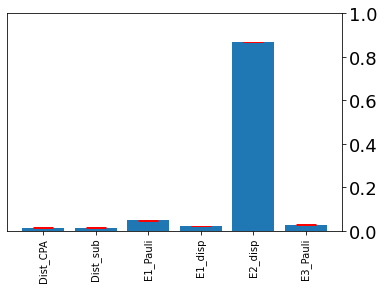

In [64]:
%matplotlib inline
# plot feature importance
plt.figure(figsize=(len(name.columns),5))
f = plt.figure()
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.tick_params(axis='y', labelsize=18)
plt.bar(name.columns, results)
plt.bar(name.columns, results, color='#1f77b4',
        yerr=w_err,
        align='center',
        #alpha=0.5,
        ecolor='red',
        capsize=10)
plt.xticks(rotation=90, horizontalalignment="center")
#plt.tick_params(axis='y', which='both', labelleft='off', labelright='off', direction='out')
plt.yticks(np.arange(0,1.1,0.2))
plt.show()

